### Processes shared memory

In [4]:
%matplotlib inline
import multiprocessing as mp
import numpy as np
from scipy import ndimage
import ctypes

import os

import astropy.io.fits as pf
import matplotlib.pyplot as plt


import sys
sys.path.append("../../libs")
import HEq

In [6]:
img = pf.getdata("LB.20140623.37347.fits")

In [7]:
img.shape

(4096, 1155)

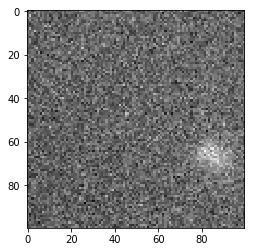

In [31]:
plt.imshow(HEq.hEqC(img)[1500:1600,500:600], cmap='gray')

In [10]:
def median2d(dataIn):
    return ndimage.median_filter(dataIn, 3) 

In [158]:
#outImg = median2d(img)
outImg = img.copy()

In [26]:
outImg[1550:1590, 550:590] = median2d(img[1550:1590, 550:590])

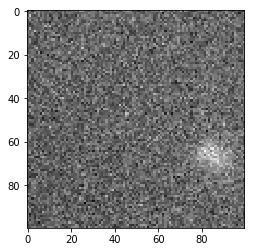

In [161]:
plt.imshow(HEq.hEqC(outImg)[1500:1600,500:600], cmap='gray')

In [55]:
_dataIn = mp.Array(ctypes.c_double, img.size)
sharedDataIn = np.ctypeslib.as_array(_dataIn.get_obj()).reshape(img.shape)
sharedDataIn[:,:] = img[:,:]

_dataOut = mp.Array(ctypes.c_double, img.size)
sharedDataOut = np.ctypeslib.as_array(_dataOut.get_obj()).reshape(img.shape)
sharedDataOut.fill(0)

In [132]:
def workerFunction (i):
    global sharedDataIn, sharedDataOut, chunkSize
    
    sy = slice(i*chunkSize, (i+1)*chunkSize)
    sx = slice(1,-1)
        
    sharedDataOut[sy,sx] = median2d(sharedDataIn[sy,sx])

In [112]:
%%timeit
nParts = 4
chunkSize = img.shape[0]//nParts
for i in range(nParts):
    workerFunction (i)

646 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


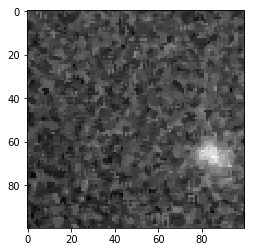

In [162]:
plt.imshow(HEq.hEqC(sharedDataOut)[1500:1600,500:600], cmap='gray')

In [152]:
def testSharedMemory(n):
    with mp.Pool(processes=6) as pool:
        pool.map(workerFunction, range(n))

In [160]:
#%%timeit
nParts = 6
testSharedMemory (nParts)